In [1]:
%matplotlib inline

In [2]:
import numpy as np 
import pandas as pd
import xarray as xr

In [3]:
last_year = 2021

In [4]:
def roll_longitudes(dset, lon_name='longitude'): 
    """
    roll the longitudes of a dataset so that it goes from 0 to 360
    instead of -180 to 180
    Parameters
    ----------
    dset : xarray.Dataset
        The input Dataset with the longitudes going from -180 to 180
    lon_name : str, optional
        The name of the longitude dimension, by default 'lon'
        
    Returns
    -------
    
    dset : xarray.Dataset 
        Dataset with rolled longitudes 
    """
    
    dset = dset.assign_coords({lon_name:(dset[lon_name] % 360)}).roll({lon_name:(dset.dims[lon_name] // 2)}, roll_coords=True)
    
    return dset

In [5]:
dset = xr.open_dataset('/media/nicolasf/END19101/data/Berkeley_Earth_Temperature/Land_and_Ocean_LatLong1.nc')

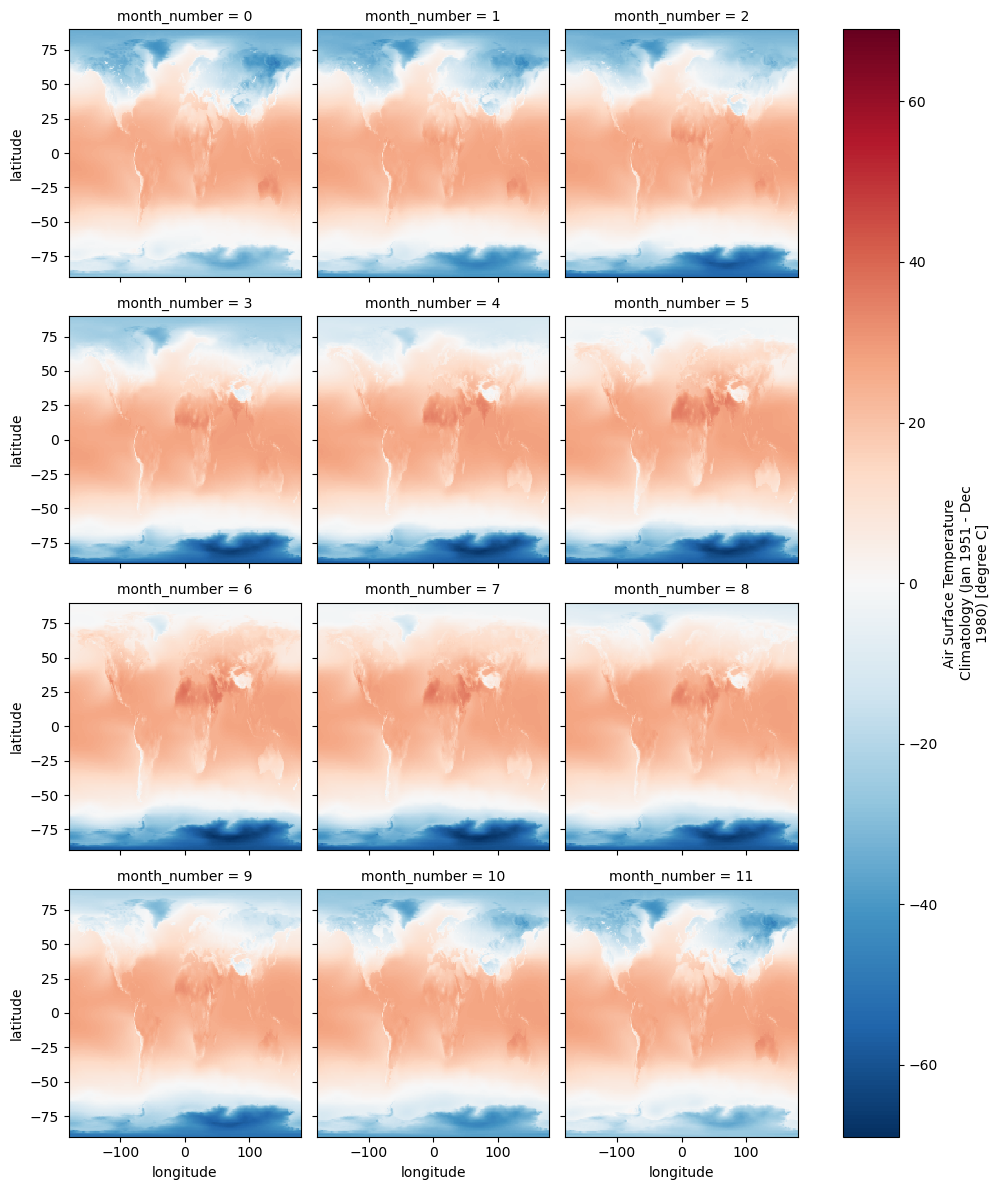

In [6]:
dset['climatology'].plot(col='month_number', col_wrap=3)

In [7]:
def convert_time(time): 
    
    from datetime import date, timedelta
    import pandas as pd
    
    dates = [date(int(x), 1, 1) + timedelta(days = (x % 1) * 365) for x in time.data]
    
    return pd.DatetimeIndex(dates)

In [8]:
time = convert_time(dset.time)

In [9]:
dset['time'] = time - pd.offsets.MonthBegin(1) 

In [10]:
dset['temperature']

<xarray.DataArray 'temperature' (time: 2073, latitude: 180, longitude: 360)>
[134330400 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2022-09-01
Attributes:
    units:          degree C
    standard_name:  surface_temperature_anomaly
    long_name:      Air Surface Temperature Anomaly
    valid_min:      -20.127740117948825
    valid_max:      25.74866232368785

In [11]:
dset['climatology'].sel(month_number=dset.time.dt.month - 1) 

<xarray.DataArray 'climatology' (time: 2073, latitude: 180, longitude: 360)>
[134330400 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2022-09-01
Attributes:
    units:          degree C
    standard_name:  surface_temperature_climatology
    long_name:      Air Surface Temperature Climatology (Jan 1951 - Dec 1980)
    valid_min:      -68.98676476566868
    valid_max:      38.244866281688054

### adds the climatology to the anomalies 

In [12]:
dset['temperature'] = dset['temperature'] + dset['climatology'].sel(month_number=dset.time.dt.month - 1)  

In [13]:
dset = roll_longitudes(dset)

In [14]:
dset = dset[['temperature']]

In [15]:
from cartopy import crs as ccrs

In [16]:
from matplotlib import pyplot as plt

In [17]:
cmap = plt.cm.get_cmap("RdBu_r").copy()

In [18]:
cmap.set_bad('0.8')

In [19]:
cbar_kwargs = {'shrink':0.5}

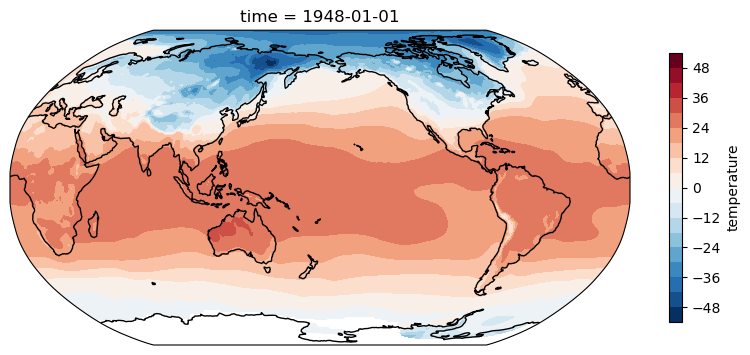

In [20]:
f, ax = plt.subplots(figsize=(10,7), subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))

dset.sel(time='1948-01-01')['temperature'].plot.contourf(levels=20, ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs=cbar_kwargs)

ax.coastlines()

In [22]:
dset = dset.rename({'latitude':'latitudes', 'longitude':'longitudes'})

In [23]:
dset = dset.sel(time=slice(None, str(last_year)))

In [24]:
dset.to_netcdf('/media/nicolasf/END19101/data/PICT/datasets/BET/BET_monthly_temperature_1850_2021.nc')